In [40]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import random

## Data

In [4]:
from transplant.tools.dataset import Dataset 

In [5]:
dataset = Dataset()

train, test = dataset.get_static()

String object to numeric ( without dealing with the time data yet ) 

In [6]:
train1=train.apply(pd.to_numeric,errors='coerce').dropna(1, how="all")

We should decide what we want to do with this NaN values ...

For the moment I replace them with the mean of the column in the training data. (Don't forget we need to do the same for the test data but without using the test data ... We use the mean of the training data to replace the NaN).

In [7]:
mean_train1 = train1.mean()

In [8]:
train1=train1.fillna(mean_train1)

In [9]:
test1=test.apply(pd.to_numeric,errors='coerce').dropna(1, how="all").fillna(mean_train1)

Here I want to be sure we get the same features 

In [10]:
drop_test1=[]
drop_train1=[]

for i in train1.columns :
    if not(i in test1.columns) :
        drop_train1+=[i]
        
for i in test1.columns :
    if not(i in train1.columns) :
        drop_test1+=[i]
drop_test1 , drop_train1

(['ATCD_chirugicaux'], [])

In [11]:
test1=test1.drop(drop_test1, axis=1)
train1=train1.drop(drop_train1, axis=1)

In [12]:
train1.shape, test1.shape

((287, 36), (123, 36))

In [13]:
test1.head()

,Age_donor,Aspirations_donor,BMI_donor,Donneur_CPT,Insuffisance_renale,LAS,PAPS,PFO,PF_donor,Poids,...,preoperative_mechanical_ventilation,preoperative_pulmonary_hypertension,preoperative_vasopressor,retransplant,sexe,super_urgence,thoracic_surgery_history,time_on_waiting_liste,transplanted_twice_during_study_period,target
284,69,1.0,31.020408,6900.0,1.0,35.1,68.884058,0.0,346.0,83.5,...,0.0,0.409894,0.0,1.0,1.0,0.0,1.0,4.0,1.0,0
29,27,2.0,24.391059,5650.0,0.0,38.1,40.000000,0.0,491.0,40.0,...,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,122.0,0.0,1
186,53,3.0,27.777778,7300.0,0.0,38.0,70.000000,1.0,275.0,69.0,...,0.0,1.000000,0.0,0.0,1.0,0.0,0.0,11.0,0.0,0
291,21,0.0,24.835646,7700.0,0.0,38.8,68.884058,1.0,492.0,68.0,...,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,6.0,0.0,0
271,41,1.0,25.661152,7450.0,0.0,51.9,96.000000,0.0,227.0,62.0,...,0.0,1.000000,0.0,0.0,0.0,0.0,1.0,28.0,0.0,1


In [14]:
dic_to_One_Hot = {0 : [1,0], 1 : [0,1]}

X_train=np.array(train1.drop(['target'], axis=1))
X_test=np.array(test1.drop(['target'], axis=1))
y_train=np.array(list(train1['target'].map(dic_to_One_Hot)))
y_test_cls=test1['target']
y_test=np.array(list(y_test_cls.map(dic_to_One_Hot)))
y_test_cls=np.array(y_test_cls)

Log Directory

In [15]:
from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

## Construction Phase

In [16]:
feature_size = X_train.shape[1]

num_classes = 2

In [17]:
x = tf.placeholder(tf.float32, [None, feature_size])
y_true = tf.placeholder(tf.float32, [None, num_classes])
y_true_cls = tf.placeholder(tf.int64, [None])
weights = tf.Variable(tf.zeros([feature_size, num_classes]))
biases = tf.Variable(tf.zeros([num_classes]))
logits = tf.matmul(x, weights) + biases
y_pred = tf.nn.softmax(logits)
y_pred_cls = tf.argmax(y_pred, axis=1)


In [18]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,
                                                           labels=y_true)
cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cost)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Running Phase

In [19]:
session = tf.Session()

In [20]:
session.run(tf.global_variables_initializer())

In [21]:
def random_batch(x,y,size) :
    mask_batch=random.sample(range(x.shape[0]), size)
    return(x[mask_batch],y[mask_batch])

In [22]:
batch_size = 100

In [23]:
def optimize(num_iterations):
    for i in range(num_iterations):

        x_batch, y_true_batch = random_batch(X_train,y_train,batch_size)
        

        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        session.run(optimizer, feed_dict=feed_dict_train)

In [24]:
feed_dict_test = {x: X_test,
                  y_true: y_test,
                  y_true_cls: y_test_cls}


In [25]:
def print_accuracy():
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    print("Accuracy on test-set: {0:.1%}".format(acc))

In [26]:
def print_confusion_matrix():

    cls_true = y_test_cls
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)

    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

## Results 

In [27]:
print_accuracy()

Accuracy on test-set: 57.7%


In [28]:
optimize(num_iterations=1)

In [29]:
print_accuracy()

Accuracy on test-set: 57.7%


In [30]:
optimize(num_iterations=10)

In [31]:
print_accuracy()

Accuracy on test-set: 57.7%


In [32]:
optimize(num_iterations=100)

In [33]:
print_accuracy()

Accuracy on test-set: 57.7%


In [34]:
optimize(num_iterations=1000)

In [35]:
print_accuracy()

Accuracy on test-set: 57.7%


In [36]:
optimize(num_iterations=10000)

In [37]:
print_accuracy()

Accuracy on test-set: 57.7%


[[71  0]
 [52  0]]


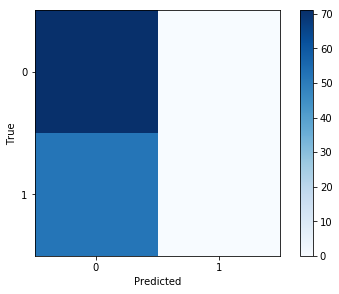

In [38]:
print_confusion_matrix()